<a href="https://colab.research.google.com/github/Y07-assine/Data-analysis-with-Pyspark/blob/main/Lab_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###ANALYSIS OF LOGS FILES OF CYCLISTS

Our missions:
1. Calculate the time foreach trip.
2. Make curves of the trip length



In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

In [3]:
ls

sample_data/  spark-2.3.1-bin-hadoop2.7/  spark-2.3.1-bin-hadoop2.7.tgz


In [4]:
import findspark
findspark.init()
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load the data

In [9]:
path = '/content/drive/MyDrive/Cyclistes/*.csv'

In [10]:
tous_tous_cyclistes = spark.read.format("csv").option("header","true").load(path,inferSchema=True)

In [11]:
tous_tous_cyclistes.count()

4868396

In [12]:
tous_tous_cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)



Let's check the number of cycles by deduplicating the column timestamp which is the column that gives us the internal time of the simulation

In [13]:
tous_tous_cyclistes.select("timestamp").drop_duplicates().count()

19396

In [14]:
tous_tous_cyclistes.take(5)

[Row(id=246, timestamp=datetime.datetime(2018, 1, 1, 0, 1), sur_velo=False, velo='False', vitesse=0.02, position='(lon:22.62 lat:9.63)', destination_finale='False'),
 Row(id=246, timestamp=datetime.datetime(2018, 1, 1, 0, 2), sur_velo=False, velo='False', vitesse=0.02, position='(lon:22.62 lat:9.63)', destination_finale='False'),
 Row(id=246, timestamp=datetime.datetime(2018, 1, 1, 0, 3), sur_velo=False, velo='False', vitesse=0.02, position='(lon:22.62 lat:9.63)', destination_finale='False'),
 Row(id=246, timestamp=datetime.datetime(2018, 1, 1, 0, 4), sur_velo=False, velo='False', vitesse=0.02, position='(lon:22.62 lat:9.63)', destination_finale='False'),
 Row(id=246, timestamp=datetime.datetime(2018, 1, 1, 0, 5), sur_velo=False, velo='False', vitesse=0.02, position='(lon:22.62 lat:9.63)', destination_finale='False')]

##Find the start time and end time of each trip

In [15]:
from pyspark.sql import functions as F

In [16]:
trip = tous_tous_cyclistes.groupBy(['id','sur_velo']).agg(F.min(tous_tous_cyclistes.timestamp),F.max(tous_tous_cyclistes.timestamp))

In [17]:
trip.take(5)

[Row(id=196, sur_velo=False, min(timestamp)=datetime.datetime(2018, 1, 1, 0, 1), max(timestamp)=datetime.datetime(2018, 1, 14, 11, 16)),
 Row(id=118, sur_velo=True, min(timestamp)=datetime.datetime(2018, 1, 1, 9, 12), max(timestamp)=datetime.datetime(2018, 1, 6, 10, 12)),
 Row(id=185, sur_velo=True, min(timestamp)=datetime.datetime(2018, 1, 1, 6, 29), max(timestamp)=datetime.datetime(2018, 1, 8, 12, 13)),
 Row(id=108, sur_velo=True, min(timestamp)=datetime.datetime(2018, 1, 1, 6, 45), max(timestamp)=datetime.datetime(2018, 1, 9, 13, 21)),
 Row(id=62, sur_velo=True, min(timestamp)=datetime.datetime(2018, 1, 1, 9, 34), max(timestamp)=datetime.datetime(2018, 1, 10, 2, 48))]

In [18]:
trip = tous_tous_cyclistes.groupBy(['id','sur_velo']).agg(F.min(tous_tous_cyclistes.timestamp),F.max(tous_tous_cyclistes.timestamp)).sort('id')

In [19]:
trip.take(5)

[Row(id=1, sur_velo=True, min(timestamp)=datetime.datetime(2018, 1, 6, 1, 51), max(timestamp)=datetime.datetime(2018, 1, 14, 5, 51)),
 Row(id=1, sur_velo=False, min(timestamp)=datetime.datetime(2018, 1, 1, 0, 1), max(timestamp)=datetime.datetime(2018, 1, 14, 11, 16)),
 Row(id=2, sur_velo=True, min(timestamp)=datetime.datetime(2018, 1, 1, 6, 27), max(timestamp)=datetime.datetime(2018, 1, 11, 20, 51)),
 Row(id=2, sur_velo=False, min(timestamp)=datetime.datetime(2018, 1, 1, 0, 1), max(timestamp)=datetime.datetime(2018, 1, 14, 11, 16)),
 Row(id=3, sur_velo=True, min(timestamp)=datetime.datetime(2018, 1, 1, 8, 8), max(timestamp)=datetime.datetime(2018, 1, 10, 11, 36))]

**Let's detect changes of state "on a bike" or not:
windows and lag functions**

In [25]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [26]:
@udf(returnType = IntegerType())
def changement(etat_actuel, etat_precedent):
  if etat_precedent == None:
    return 0
  if etat_precedent == etat_actuel:
    return 0
  if etat_actuel != etat_precedent:
    return 1 

In [27]:
from pyspark.sql.window import Window

In [33]:
W = Window.orderBy(['id','timestamp'])

In [34]:
F.lag("sur_velo",0).over(W)

Column<b'lag(sur_velo, 0, NULL) OVER (ORDER BY id ASC NULLS FIRST, timestamp ASC NULLS FIRST unspecifiedframe$())'>

In [35]:
F.lag("sur_velo",1).over(W)

Column<b'lag(sur_velo, 1, NULL) OVER (ORDER BY id ASC NULLS FIRST, timestamp ASC NULLS FIRST unspecifiedframe$())'>

**Spark LAG function provides access to a row at a given offset that comes before the current row in the windows. This function can be used in a SELECT statement to compare values in the current row with values in a previous row.**

We will therefore be able to pass two lag functions to our UDF: one
returning the current value (with the second parameter at 0) and the other the
previous value (second parameter to 1)

In [36]:
tous_tous_cyclistes = tous_tous_cyclistes.withColumn("changement",changement(F.lag("sur_velo",0).over(W),F.lag("sur_velo",1).over(W)))

In [37]:
tous_tous_cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)
 |-- changement: integer (nullable = true)



We can then follow a cyclist and see that the changes are good
detected: each time the log size changes, a number 1 appears in the
change field level

In [38]:
tous_tous_cyclistes.select("id","timestamp","velo","changement").sort('id','timestamp').collect()

[Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 1), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 2), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 3), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 4), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 5), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 6), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 7), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 8), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 9), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 10), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(2018, 1, 1, 0, 11), velo='False', changement=0),
 Row(id=1, timestamp=datetime.datetime(20

We have built a Boolean column that detects the
changes. Now we want to add this column from top to
low ", by sub-group. This will have calculated the index of the trip.

We are going to need a function that allows us to:
1. Order the lines by cyclist and by date
2. Divide by cyclist
3. Add all the lines above
the current line

For this we will use a specialized windowing function with an option `rangeBetween` that is placed with the option `window.unboundedPreceding`

In [41]:
windowval = Window.orderBy(['id','timestamp'])
windowval = windowval.partitionBy('id')
windowval = windowval.rangeBetween(Window.unboundedPreceding,0)

In [42]:
tous_tous_cyclistes = tous_tous_cyclistes.withColumn('numero_de_traget',F.sum("changement").over(windowval))

In [43]:
tous_tous_cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)
 |-- changement: integer (nullable = true)
 |-- numero_de_traget: long (nullable = true)



In [44]:
tous_tous_cyclistes.select("id","timestamp","changement","numero_de_traget").take(5)

[Row(id=148, timestamp=datetime.datetime(2018, 1, 1, 0, 1), changement=0, numero_de_traget=0),
 Row(id=148, timestamp=datetime.datetime(2018, 1, 1, 0, 2), changement=0, numero_de_traget=0),
 Row(id=148, timestamp=datetime.datetime(2018, 1, 1, 0, 3), changement=0, numero_de_traget=0),
 Row(id=148, timestamp=datetime.datetime(2018, 1, 1, 0, 4), changement=0, numero_de_traget=0),
 Row(id=148, timestamp=datetime.datetime(2018, 1, 1, 0, 5), changement=0, numero_de_traget=0)]

##Calculate the time of the trip

In [45]:
cyclistes = tous_tous_cyclistes
debut_fin_traget = cyclistes.groupBy(['id','numero_de_traget']).agg(F.min(tous_tous_cyclistes.timestamp),F.max(tous_tous_cyclistes.timestamp))

In [46]:
debut_fin_traget.take(4)

[Row(id=148, numero_de_traget=0, min(timestamp)=datetime.datetime(2018, 1, 1, 0, 1), max(timestamp)=datetime.datetime(2018, 1, 6, 10, 5)),
 Row(id=148, numero_de_traget=1, min(timestamp)=datetime.datetime(2018, 1, 6, 10, 6), max(timestamp)=datetime.datetime(2018, 1, 7, 8, 30)),
 Row(id=148, numero_de_traget=2, min(timestamp)=datetime.datetime(2018, 1, 7, 8, 31), max(timestamp)=datetime.datetime(2018, 1, 7, 16, 1)),
 Row(id=148, numero_de_traget=3, min(timestamp)=datetime.datetime(2018, 1, 7, 16, 2), max(timestamp)=datetime.datetime(2018, 1, 8, 7, 34))]

Now we should do the substraction of this minimum date in the maximum date, in order to calculate the duration.
It turn out that for y archieve it will turn the timestamp objects into new objects unix_timestamp throught the function F.unix_timestamp.

In [47]:
cyclistes.agg(F.unix_timestamp(F.max(tous_tous_cyclistes.timestamp))-F.unix_timestamp(F.min(tous_tous_cyclistes.timestamp)))

DataFrame[(unix_timestamp(max(timestamp), yyyy-MM-dd HH:mm:ss) - unix_timestamp(min(timestamp), yyyy-MM-dd HH:mm:ss)): bigint]

In [48]:
cyclistes = cyclistes.groupBy(["id","numero_de_traget"])

In [49]:
cyclistes = cyclistes.agg(F.unix_timestamp(F.max(tous_tous_cyclistes.timestamp))-F.unix_timestamp(F.min(tous_tous_cyclistes.timestamp)))

In [50]:
cyclistes = cyclistes.sort('id')

In [51]:
cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- numero_de_traget: long (nullable = true)
 |-- (unix_timestamp(max(timestamp), yyyy-MM-dd HH:mm:ss) - unix_timestamp(min(timestamp), yyyy-MM-dd HH:mm:ss)): long (nullable = true)



In [52]:
cyclistes = cyclistes.withColumnRenamed("(unix_timestamp(max(timestamp), yyyy-MM-dd HH:mm:ss) - unix_timestamp(min(timestamp), yyyy-MM-dd HH:mm:ss))","duree")

In [53]:
cyclistes.take(4)

[Row(id=1, numero_de_traget=2, duree=85080),
 Row(id=1, numero_de_traget=0, duree=438540),
 Row(id=1, numero_de_traget=1, duree=1200),
 Row(id=1, numero_de_traget=3, duree=960)]

**`we have therefore manage to calculate the duration of each trip for each cylists`**

##Switch from spark to Pandas to do graphics

In [54]:
df = cyclistes.toPandas()

In [56]:
df.head()

,id,numero_de_traget,duree
0,1,0,438540
1,1,1,1200
2,1,2,85080
3,1,3,960
4,1,4,517680


In [55]:
%matplotlib inline
import seaborn as sns

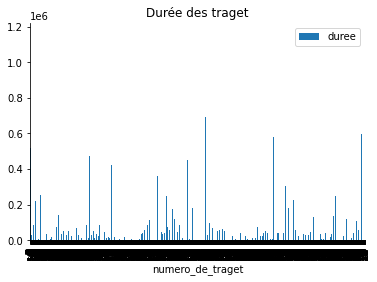

In [58]:
df.sort_values(["id","numero_de_traget"]).plot(kind="bar",x="numero_de_traget",y="duree",title="Durée des traget")
sns.despine()

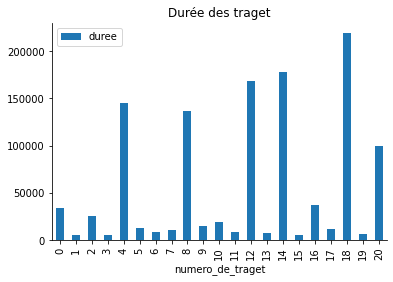

In [60]:
num_cycliste = [40]
filter = df.id.isin(num_cycliste)
df[filter].plot(kind="bar",x="numero_de_traget",y="duree",title="Durée des traget")
sns.despine()